<a href="https://colab.research.google.com/github/JacobyNevada/ds_belhard/blob/main/hw3/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Все столбцы:

observation_id | common_name                        | scientific_name        | family       | genus       | observed_length | observed_weight | age_class | sex     | date_of_observation | country_or_region        | habitat_type      | conservation_status   | observer_name         | notes                                                                                                                          
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1              | Morelet's Crocodi

/tmp/ipython-input-2129488957.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_all, y='country_or_region', order=df_all['country_or_region'].value_counts().index, palette="rocket")


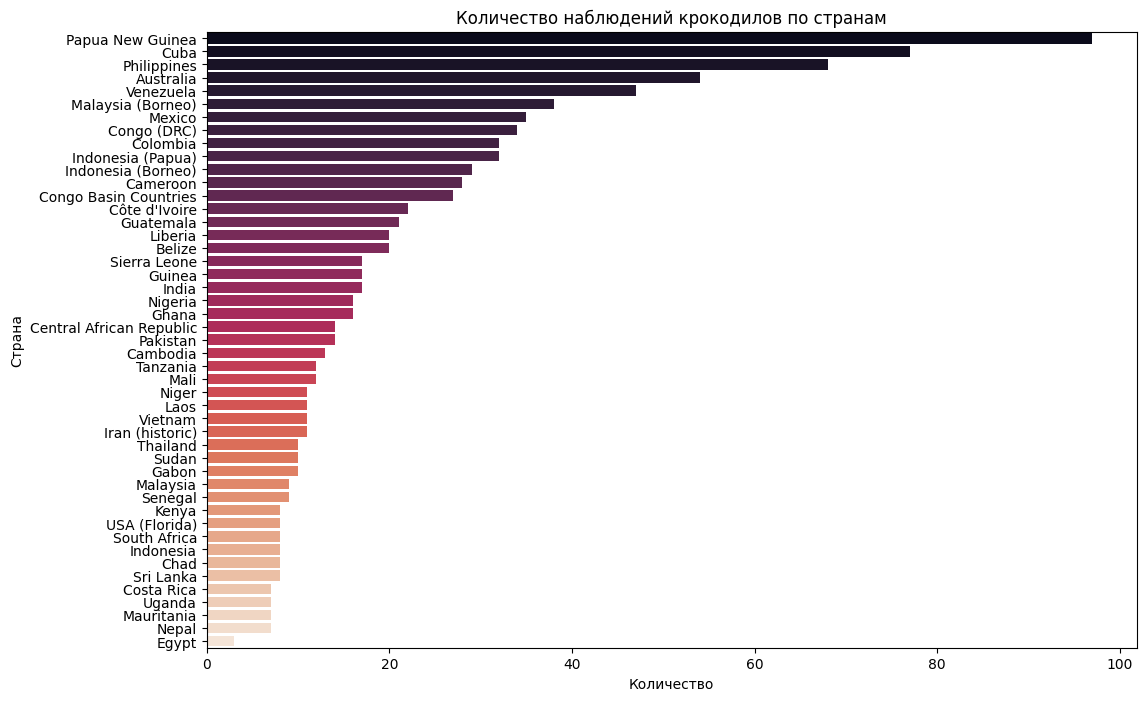

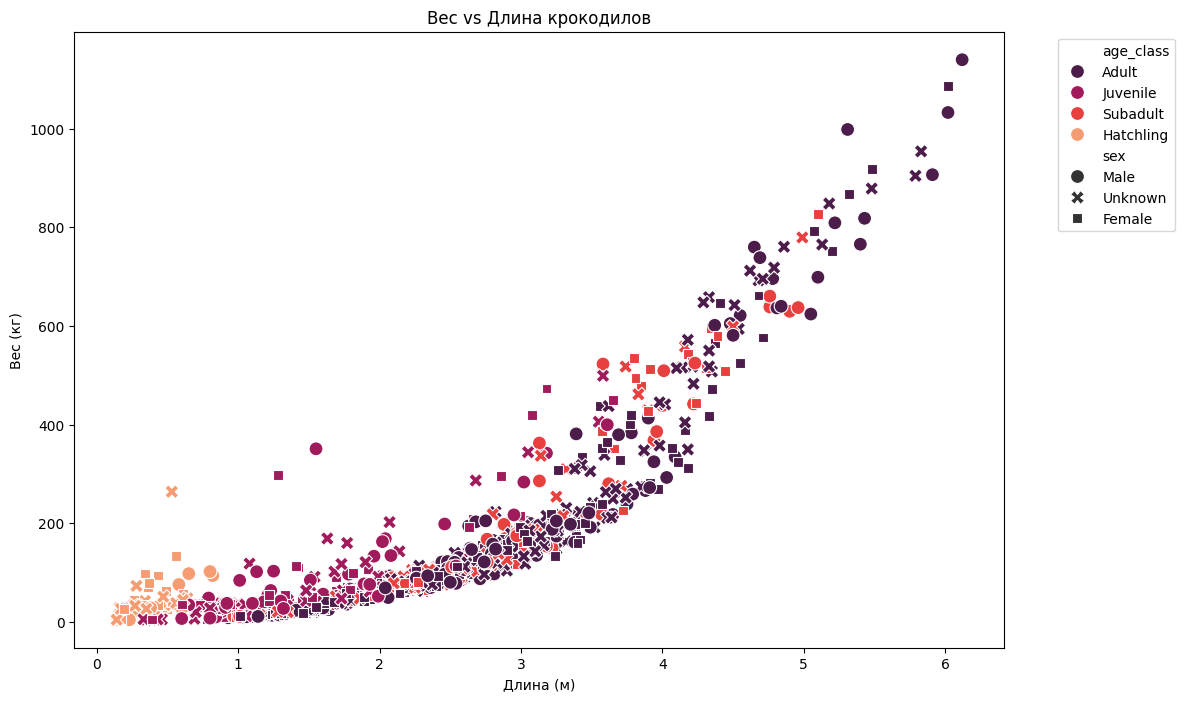

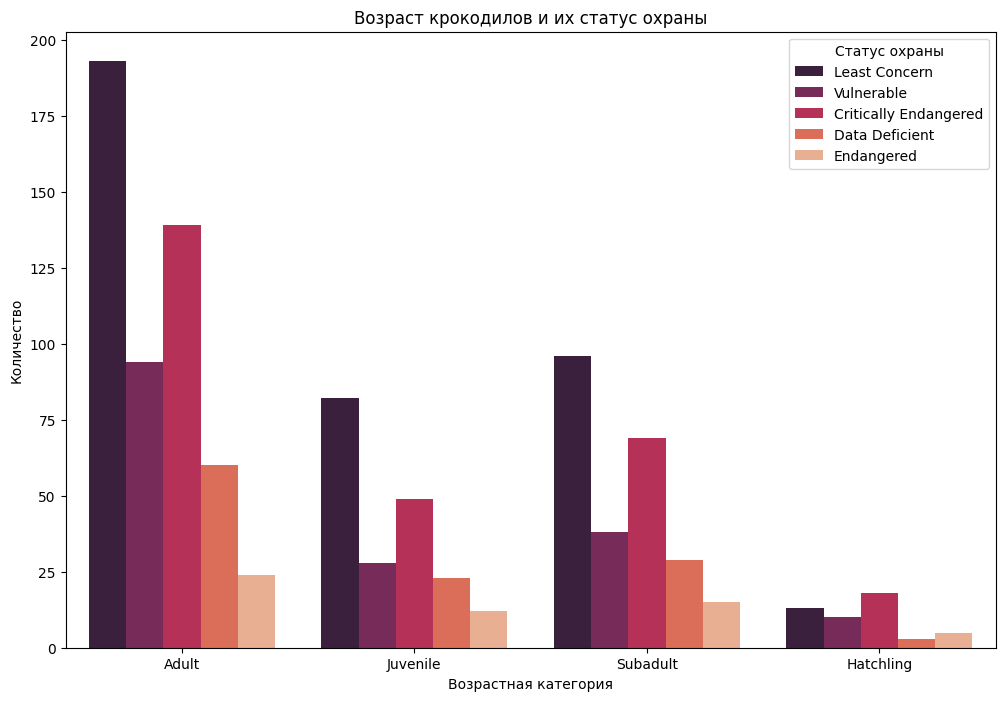

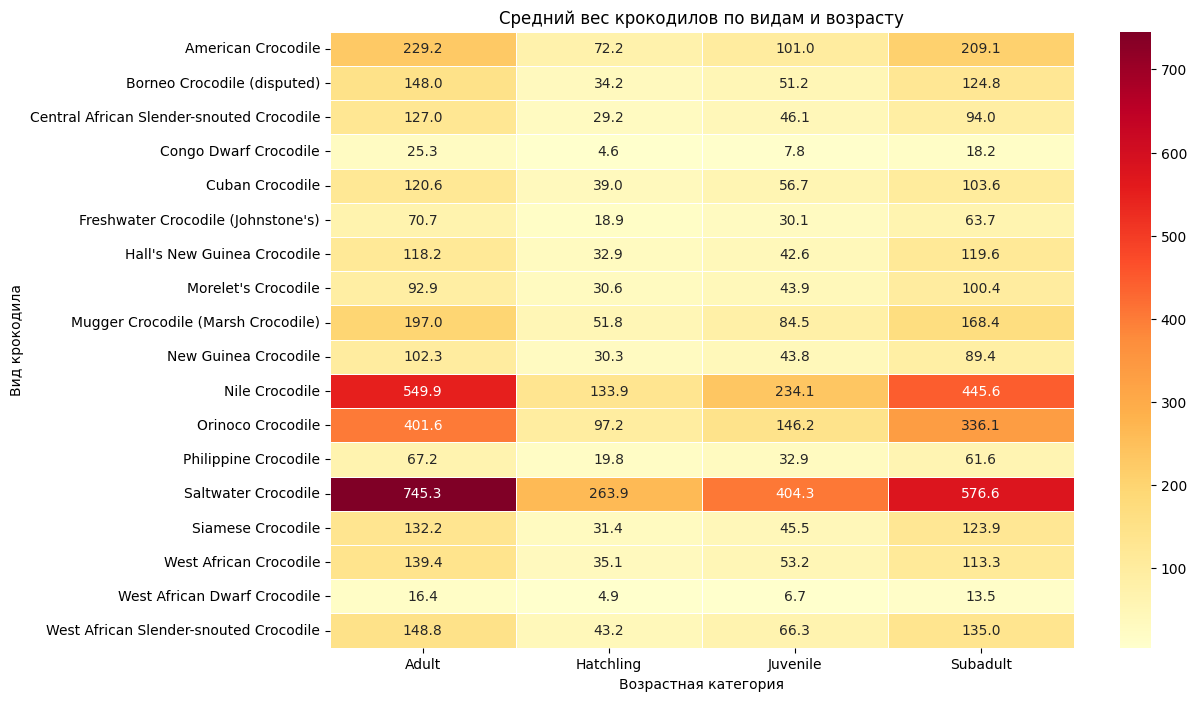

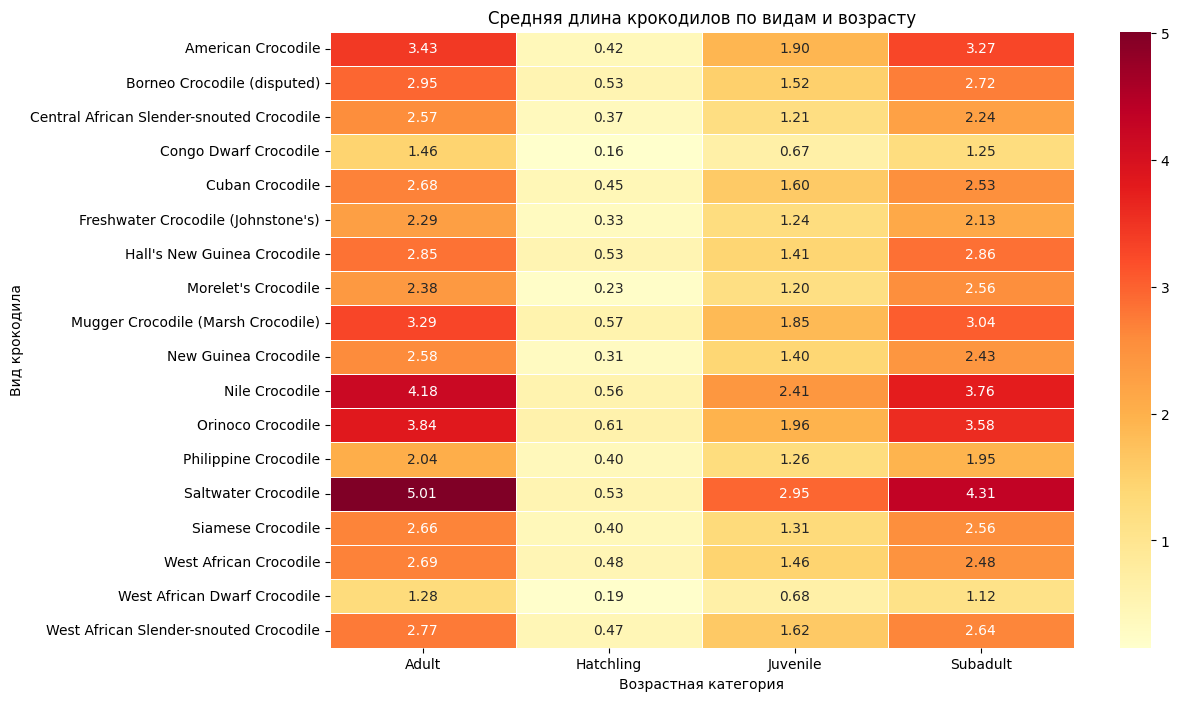

/tmp/ipython-input-2129488957.py:182: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_heavy, x='observed_weight', y='common_name', hue='age_class', ci=None, palette="magma")


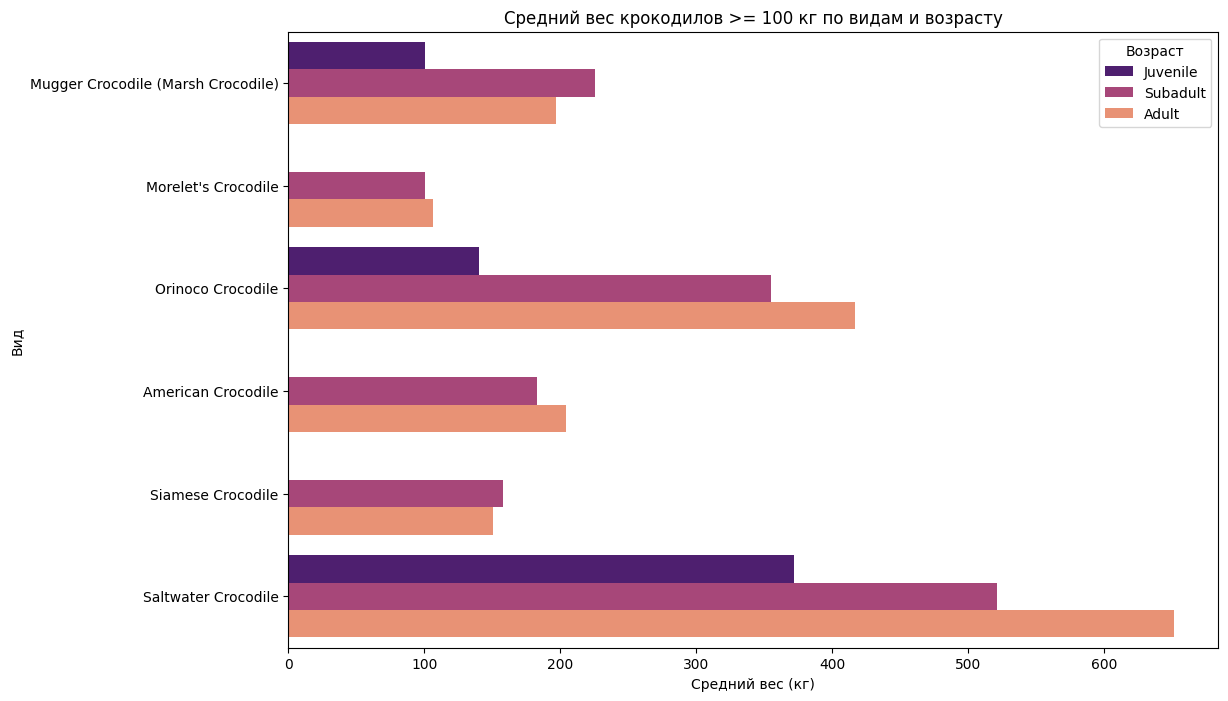

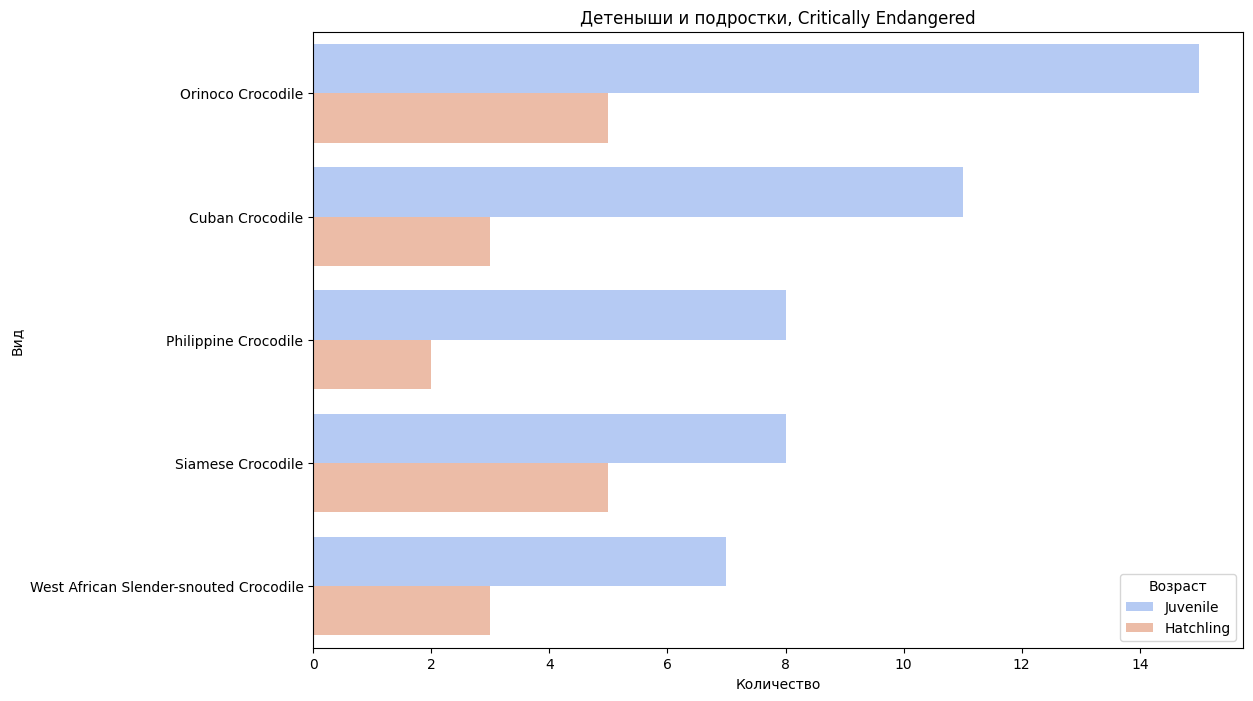

In [77]:
import pandas as pd
from google.colab import drive
import os
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

def data_loading(file_link):
  drive.mount('/content/drive')
  file_path = f"/content/drive/{file_link}"

  # Загрузка CSV файла
  dataset = pd.read_csv(file_path)
  return dataset

def pretty_select(cursor, query, limit=None):

    # Добавляем LIMIT если надо
    if limit and "limit" not in query.lower():
        query = f"{query.strip()} LIMIT {limit}"

    cursor.execute(query)
    rows = cursor.fetchall()

    if not rows:
        print("Нет данных")
        return

    # Получаем список названий колонок
    col_names = [desc[0] for desc in cursor.description]

    # Определяем ширину колонок
    col_widths = []
    for i, col in enumerate(col_names):
        max_len = max(len(str(row[i])) for row in rows) if rows else 0
        col_widths.append(max(len(col), max_len))

    # Функция для форматирования строки
    def format_row(row):
        return " | ".join(str(val).ljust(width) for val, width in zip(row, col_widths))

    # Печатаем заголовок
    print(format_row(col_names))
    print("-" * (sum(col_widths) + 3 * (len(col_widths) - 1)))

    # Печатаем строки
    for row in rows:
        print(format_row(row))

#################################################################3

# https://www.kaggle.com/datasets/zadafiyabhrami/global-crocodile-species-dataset
file_link = 'MyDrive/Colab Notebooks/hw3/crocodile_dataset.csv'
dataset = data_loading(file_link)


# Подключение к базе данных SQLite
conn = sqlite3.connect('hw3.db')
cursor = conn.cursor()

# Создание таблицы
cursor.execute('''DROP TABLE IF EXISTS crocodiles''')

cursor.execute('''CREATE TABLE IF NOT EXISTS crocodiles (
                    observation_id integer primary key,
                    common_name varchar2,
                    scientific_name varchar2,
                    family varchar2,
                    genus varchar2,
                    observed_length numeric,
                    observed_weight numeric,
                    age_class varchar2,
                    sex varchar2,
                    date_of_observation date,
                    country_or_region varchar2,
                    habitat_type varchar2,
                    conservation_status varchar2,
                    observer_name varchar2,
                    notes varchar2
                  )''')

# Превращаем DataFrame в список кортежей
data_tuples = dataset.to_records(index=False).tolist()

# Вставка данных
cursor.executemany("""INSERT INTO crocodiles (observation_id, common_name, scientific_name, family, genus,
                                              observed_length, observed_weight, age_class, sex, date_of_observation,
                                              country_or_region, habitat_type, conservation_status, observer_name, notes
                                             ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)""", data_tuples)


query_all = "SELECT * FROM crocodiles"

query_heavy = """SELECT common_name,
                        age_class,
                        sex,
                        round(avg(observed_length), 2) as observed_length,
                        round(avg(observed_weight), 2) as observed_weight,
                        count(*) as count,
                        min(date_of_observation) over (partition by common_name) as min_date,
                        max(date_of_observation) over (partition by common_name) as max_date
                  FROM crocodiles
                  where country_or_region in ('Venezuela', 'Thailand', 'India', 'Mexico')
                  group by common_name,
                          age_class,
                          sex
                  having round(avg(observed_weight), 2) >= 100
                  order by observed_weight, common_name, age_class, sex"""

query_critical =  """SELECT common_name,
                            conservation_status,
                            age_class,
                            count(*) as count
                      FROM crocodiles
                      where conservation_status = 'Critically Endangered'
                          and age_class in ('Hatchling', 'Juvenile')
                      group by common_name,
                              conservation_status,
                              age_class
                      order by count desc, common_name, conservation_status, age_class"""

# Запрос данных
print('\nВсе столбцы:\n')
pretty_select(cursor, query_all, limit=30)

print('\nТип крокодилов из Венесуэлы, Тайланда, Индии, Мексики, средний вес которых >= 100 кг (среди своего возраста и пола):\n')
pretty_select(cursor, query_heavy)

print('\nТип крокодилов, детеныши и подростки которых подвержены критической опасности:\n')
pretty_select(cursor, query_critical)


# Визуализация
df_all = pd.read_sql(query_all, conn)

plt.figure(figsize=(12,8))
sns.countplot(data=df_all, y='country_or_region', order=df_all['country_or_region'].value_counts().index, palette="rocket")
plt.title('Количество наблюдений крокодилов по странам')
plt.xlabel('Количество')
plt.ylabel('Страна')
plt.show()

plt.figure(figsize=(12,8))
sns.scatterplot(data=df_all, x='observed_length', y='observed_weight', hue='age_class', style='sex', palette="rocket", s=100)
plt.title('Вес vs Длина крокодилов')
plt.xlabel('Длина (м)')
plt.ylabel('Вес (кг)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

plt.figure(figsize=(12,8))
sns.countplot(data=df_all, x='age_class', hue='conservation_status', palette="rocket")
plt.title('Возраст крокодилов и их статус охраны')
plt.xlabel('Возрастная категория')
plt.ylabel('Количество')
plt.legend(title='Статус охраны')
plt.show()

# heatmap по весу
pivot_weight = df_all.pivot_table(index='common_name', columns='age_class', values='observed_weight', aggfunc='mean')
plt.figure(figsize=(12,8))
sns.heatmap(pivot_weight, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=.5)
plt.title('Средний вес крокодилов по видам и возрасту')
plt.xlabel('Возрастная категория')
plt.ylabel('Вид крокодила')
plt.show()

# heatmap по длине
pivot_length = df_all.pivot_table(index='common_name', columns='age_class', values='observed_length', aggfunc='mean')
plt.figure(figsize=(12,8))
sns.heatmap(pivot_length, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=.5)
plt.title('Средняя длина крокодилов по видам и возрасту')
plt.xlabel('Возрастная категория')
plt.ylabel('Вид крокодила')
plt.show()



df_heavy = pd.read_sql(query_heavy, conn)

plt.figure(figsize=(12,8))
sns.barplot(data=df_heavy, x='observed_weight', y='common_name', hue='age_class', ci=None, palette="magma")
plt.title('Средний вес крокодилов >= 100 кг по видам и возрасту')
plt.xlabel('Средний вес (кг)')
plt.ylabel('Вид')
plt.legend(title='Возраст')
plt.show()



df_critically = pd.read_sql(query_critical, conn)

plt.figure(figsize=(12,8))
sns.barplot(data=df_critically, x='count', y='common_name', hue='age_class', palette="coolwarm")
plt.title('Детеныши и подростки, Critically Endangered')
plt.xlabel('Количество')
plt.ylabel('Вид')
plt.legend(title='Возраст')
plt.show()


# Закрытие соединения
conn.commit()
conn.close()
